In [109]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
from collections import Counter
import matplotlib
import scipy
import random

In [2]:
gpus = tf.config.experimental.list_physical_devices( device_type = 'GPU' )
# 设置该程序可见的GPU：写到最前面！
tf.config.experimental.set_visible_devices( devices = gpus[2:4], device_type = 'GPU' )

### 1. 导入所有文件的路径：

In [3]:
# 所有训练图片的地址：
image_path = glob.glob( '/home/gaoboyu/学习数据集/沙漠数据集12_450/图像/*' )
label_path = glob.glob( '/home/gaoboyu/学习数据集/沙漠数据集12_450/处理后标签/*' )
# 排序：
image_path.sort( key = lambda x:int(x.split('/')[-1].split('.')[0].split('_')[-1]) )
label_path.sort( key = lambda x:int(x.split('/')[-1].split('.')[0].split('_')[-1]) )

In [4]:
image_count = len(image_path)
len(image_path), len(label_path)

(450, 450)

In [115]:
# 最后数据的乱序：
index = np.random.permutation( image_count )  # 每次都不一样！
image_path = np.array(image_path)[index]
label_path = np.array(label_path)[index]

In [116]:
train_image_path = image_path[0:360]; val_image_path = image_path[360:450]
train_label_path = label_path[0:360]; val_label_path = label_path[360:450]

### 2. 创建数据集：

In [38]:
train_dataset = tf.data.Dataset.from_tensor_slices( (train_image_path, train_label_path) )
val_dataset = tf.data.Dataset.from_tensor_slices( (val_image_path, val_label_path) )
# 查看：
train_dataset, val_dataset

(<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.string)>,
 <TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.string)>)

### 3. 预处理函数：

In [8]:
# 读取图片：3通道
def read_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels = 3)
    return img

In [9]:
# 读取标签：1通道（每个像素都是标签值）
def read_label(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels = 1)
    return img

In [10]:
# 对训练数据及标签：随机翻转 —— 训练数据专用！
def random_flip(img, label):
    img_label = tf.concat( [img, label], axis = -1 )  # 图像与标签合并
    img_label = tf.image.resize(img_label, [256,256])
    img_label = tf.image.random_flip_left_right(img_label)  # 随机左右翻转
    img_label = tf.image.random_flip_up_down(img_label)     # 随机上下翻转
    return img_label[:,:,0:3], img_label[:,:,3:]

In [11]:
# 所有图像归一化 + 标签转数据类型：
def normal(img, label):
    img = tf.cast(img, tf.float32) / 127.5 - 1
    label = tf.cast(label, tf.int32)  # 不能减1，因为里面本身就有0的标签！ 
    return img, label

In [12]:
# 训练数据加载：需要裁减！
def load_train_image(img_path, label_path):
    # 获取图片与标签：
    img = read_image(img_path)
    label = read_label(label_path)
    # 预处理：随机翻转 —— 自带统一形状！
    img, label = random_flip(img, label)
    # 返回归一化：
    return normal(img, label)

def load_val_image(img_path, label_path):
    # 获取图片与标签：
    img = read_image(img_path)
    label = read_label(label_path)
    # 统一形状：
    img = tf.image.resize(img, [256,256])
    label = tf.image.resize(label, [256,256])
    # 返回归一化：
    return normal(img, label)

In [39]:
# 将数据应用于函数：
AUTOTUNE = tf.data.experimental.AUTOTUNE   # 多线程加载：图像加载是cpu处理的，cpu可以做多线程！

train_dataset = train_dataset.map( load_train_image, num_parallel_calls = AUTOTUNE )
val_dataset = val_dataset.map( load_val_image, num_parallel_calls = AUTOTUNE )

# 乱序、划分数据集：
# cashe()：新操作，文件不断放到缓存中，加速！
# prefetch()：新操作，GPU内存不等待，不断预处理图片
BATCH_SIZE = 10
train_dataset = train_dataset.cache().shuffle(train_count).repeat().batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_dataset = val_dataset.cache().batch(BATCH_SIZE)

In [40]:
train_dataset, val_dataset

(<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.int32)>,
 <BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.int32)>)

### 4. 导入训练好的模型：

In [ ]:
model = tf.keras.models.load_model( 'model12_450_调过拟合.h5' )
model.evaluate( val_dataset )  # 这个val_dataset必须得每次更新！

只用变以下内容：

In [156]:
# 最后数据的乱序：
index = np.random.permutation( image_count )  # 每次都不一样！
image_path = np.array(image_path)[index]
label_path = np.array(label_path)[index]
# 重换数据：
train_image_path = image_path[0:350]; val_image_path = image_path[350:450]
train_label_path = label_path[0:350]; val_label_path = label_path[350:450]

### 5. 计算IoU：

In [157]:
val_images = []
val_labels = [] 
val_count = len(val_label_path)

for x in range(val_count):
    image_tmp, label_tmp = load_val_image( val_image_path[x], val_label_path[x] )
    val_images.append( image_tmp )
    val_labels.append( label_tmp )

In [158]:
# # 查看每个元素：
# val_images[0].shape, val_labels[0].shape
# # 查看自定标签是否正确：
# np.max(val_labels[0]), np.min(val_labels[0])

In [159]:
# 开始预测：
val_pred_labels = [] 
for x in range(val_count):
    image_tmp = tf.expand_dims( val_images[x], axis = 0 )
    # 拓维 + 预测：
    pred_tmp = model.predict( image_tmp )
    pred_tmp = tf.argmax( pred_tmp, axis = -1 )
    # 恢复原形：
    pred_tmp = tf.squeeze( pred_tmp, axis = 0 )
    # 添加：
    val_pred_labels.append(pred_tmp)

In [160]:
len(val_pred_labels)

100

In [161]:
IoU = []
for x in range(val_count):
    cs_pred = val_pred_labels[x]
    cs_o = tf.squeeze( val_labels[x], axis = -1 )
    # 计算IoU：
    w = tf.metrics.MeanIoU( num_classes = 2 )
    w.update_state( cs_pred, cs_o )
    IoU.append( w.result().numpy() )
    # w复原：
    w.reset_states()

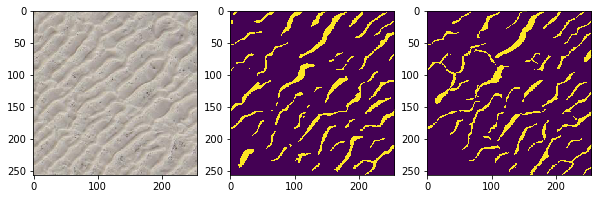

In [162]:
plt.figure( figsize = (10,10) )
plt.subplot(1,3,1)
plt.imshow( (val_images[0] + 1)/2 )
plt.subplot(1,3,2)
plt.imshow(cs_pred)
plt.subplot(1,3,3)
plt.imshow(cs_o)

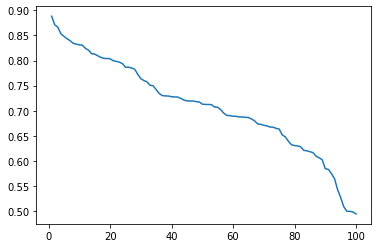

In [167]:
x = [x+1 for x in range(val_count)]
g = sorted( IoU, reverse = True )  # 正序
plt.plot( x, g )

(array([1.24382156, 1.06613389, 2.13226553, 4.97528623, 3.37608708,
        3.37609066, 1.59919915]),
 array([0.49435425, 0.5506324 , 0.6069105 , 0.6631887 , 0.71946687,
        0.77574503, 0.83202314, 0.8883013 ], dtype=float32),
 <a list of 7 Patch objects>)

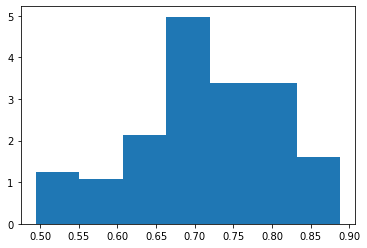

In [171]:
plt.hist( g, bins = 7, density = True,  )